In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import tides
import parameters as param
import mpi4py.MPI as MPI
import uuid
import logging
logger = logging.getLogger(__name__)
%matplotlib notebook

In [2]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Hg/pg_coupling/compressible/notebooks/parameters.py'>

## 1D linear tide

In [3]:
domain, problem = tides.linear_tide_1d(param)
solver = problem.build_solver()
solver.solve()

2017-08-17 16:39:22,303 domain 0/1 DEBUG :: Global coeff shape: [128]
2017-08-17 16:39:22,304 distributor 0/1 DEBUG :: Mesh: []
2017-08-17 16:39:22,308 problems 0/1 DEBUG :: Parsing Eqn 0
2017-08-17 16:39:22,308 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:39:22,309 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2017-08-17 16:39:22,310 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2017-08-17 16:39:22,312 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2017-08-17 16:39:22,313 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2017-08-17 16:39:22,317 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2017-08-17 16:39:22,320 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2017-08-17 16:39:22,320 problems 0/1 DEBUG :: Parsing Eqn 1
2017-08-17 16:39:22,321 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:39:22,322 

2017-08-17 16:39:23,288 problems 0/1 DEBUG ::   RHS object form: 0
2017-08-17 16:39:23,290 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2017-08-17 16:39:23,291 problems 0/1 DEBUG :: Parsing BC 0
2017-08-17 16:39:23,291 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:39:23,292 problems 0/1 DEBUG ::   LHS string form: left(txz)
2017-08-17 16:39:23,293 problems 0/1 DEBUG ::   RHS string form: 0
2017-08-17 16:39:23,294 problems 0/1 DEBUG ::   LHS object form: interp(μ*(((1j*k)*w) + uz),'z',left)
2017-08-17 16:39:23,294 problems 0/1 DEBUG ::   RHS object form: 0
2017-08-17 16:39:23,296 problems 0/1 DEBUG ::   L linear form: interp((μ*(1j*k))*w,'z',left) + interp(μ*uz,'z',left)
2017-08-17 16:39:23,297 problems 0/1 DEBUG :: Parsing BC 1
2017-08-17 16:39:23,298 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:39:23,298 problems 0/1 DEBUG ::   LHS string form: right(txz)
2017-08-17 16:39:23,299 problems 0/1 DEBUG ::   RHS string form: 0
2017-08-17 16:39:23,300 problems 0/1 

<IPython.core.display.Javascript object>


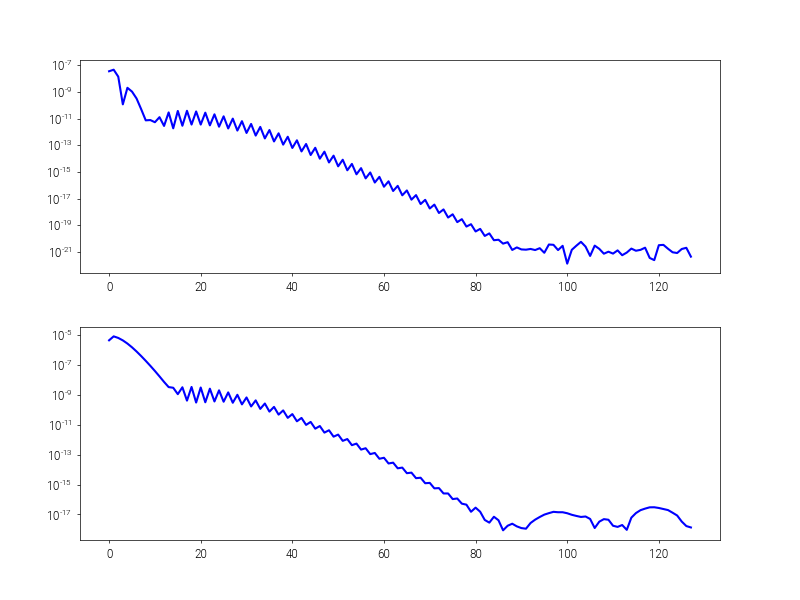

In [4]:
scales = 1
z = domain.grid(0, scales=scales)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.semilogy(np.abs(solver.state['p1']['c']))
ax2.semilogy(np.abs(solver.state['a1']['c']))

<IPython.core.display.Javascript object>


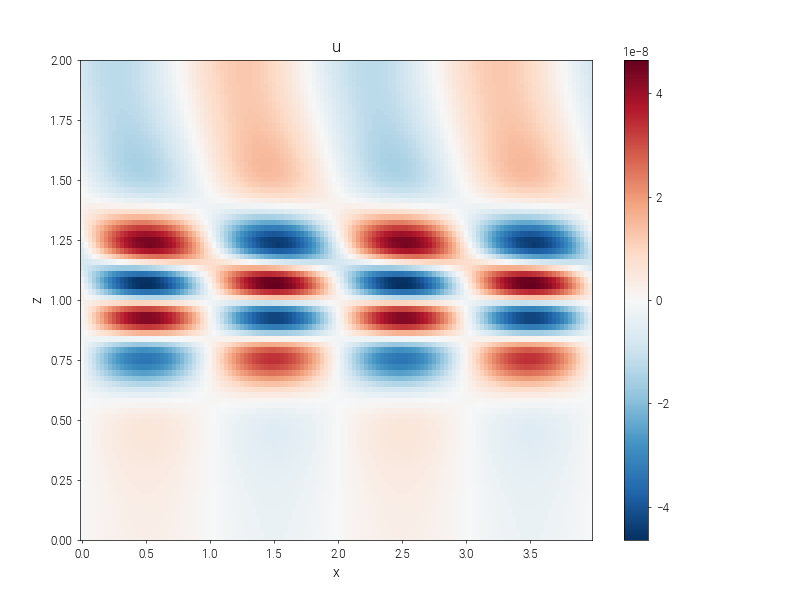

In [5]:
scales = 1

kx = param.k_tide
x = np.linspace(0, param.Lx, param.Nx, endpoint=False)[:,None]
z = domain.grid(0, scales=scales)
Z, X = plot_tools.quad_mesh(z.flatten(), x.flatten())

field = 'u'
f = solver.state[field]
f.set_scales(scales)
fig, axes = plt.subplots(1, 1)
im = axes.pcolormesh(X, Z, np.real(np.exp(1j*kx*x)*f['g']))
plt.colorbar(im)
axes.set_title(field)
axes.set_xlabel('x')
axes.set_ylabel('z')

## 2D linear tide

In [6]:
domain2, problem2 = tides.linear_tide_2d(param)
solver2 = problem2.build_solver()
solver2.solve()

2017-08-17 16:39:24,658 domain 0/1 DEBUG :: Global coeff shape: [128]
2017-08-17 16:39:24,659 distributor 0/1 DEBUG :: Mesh: []
2017-08-17 16:39:24,661 problems 0/1 DEBUG :: Parsing Eqn 0
2017-08-17 16:39:24,662 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:39:24,663 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2017-08-17 16:39:24,664 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2017-08-17 16:39:24,666 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2017-08-17 16:39:24,667 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2017-08-17 16:39:24,671 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2017-08-17 16:39:24,673 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2017-08-17 16:39:24,674 problems 0/1 DEBUG :: Parsing Eqn 1
2017-08-17 16:39:24,674 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:39:24,675 

2017-08-17 16:39:25,574 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2017-08-17 16:39:25,575 problems 0/1 DEBUG ::   RHS string form: 0
2017-08-17 16:39:25,576 problems 0/1 DEBUG ::   LHS object form: wz + (-1*dz(w))
2017-08-17 16:39:25,576 problems 0/1 DEBUG ::   RHS object form: 0
2017-08-17 16:39:25,578 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2017-08-17 16:39:25,578 problems 0/1 DEBUG :: Parsing BC 0
2017-08-17 16:39:25,579 problems 0/1 DEBUG ::   Condition: nx != 0
2017-08-17 16:39:25,579 problems 0/1 DEBUG ::   LHS string form: left(txz)
2017-08-17 16:39:25,580 problems 0/1 DEBUG ::   RHS string form: 0
2017-08-17 16:39:25,581 problems 0/1 DEBUG ::   LHS object form: interp(μ*(dx(w) + uz),'z',left)
2017-08-17 16:39:25,582 problems 0/1 DEBUG ::   RHS object form: 0
2017-08-17 16:39:25,583 problems 0/1 DEBUG ::   L linear form: interp(μ*dx(w),'z',left) + interp(μ*uz,'z',left)
2017-08-17 16:39:25,584 problems 0/1 DEBUG :: Parsing BC 1
2017-08-17 16:39:25,585 pro

2017-08-17 16:39:31,198 basis 0/1 DEBUG :: Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (256, 256), 0)
2017-08-17 16:39:31,215 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (64, 256), 1)


<IPython.core.display.Javascript object>


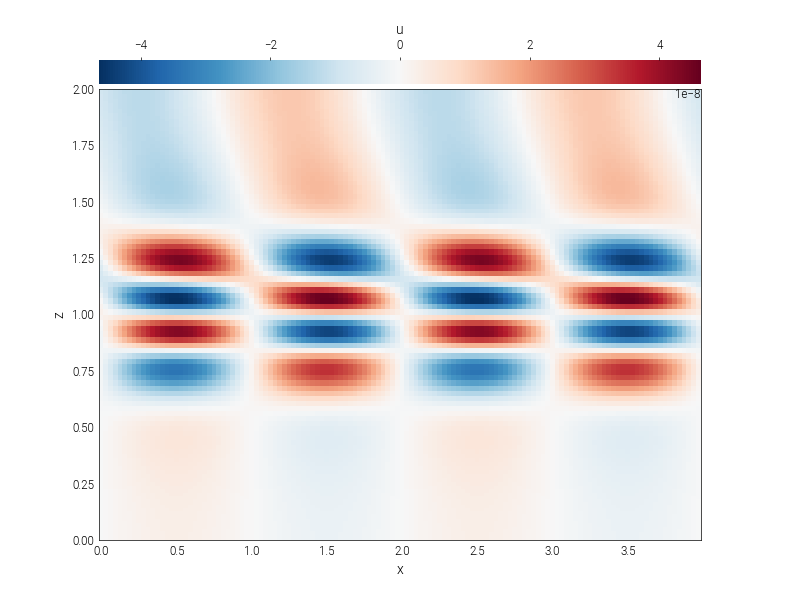

(<matplotlib.axes._axes.Axes at 0x10d279b38>,
 <matplotlib.axes._axes.Axes at 0x10f70c4a8>)

In [7]:
fig, axes = plt.subplots(1, 1)
solver2.state['u'].require_grid_space()
plot_tools.plot_bot_2d(solver2.state['u'], axes=axes)